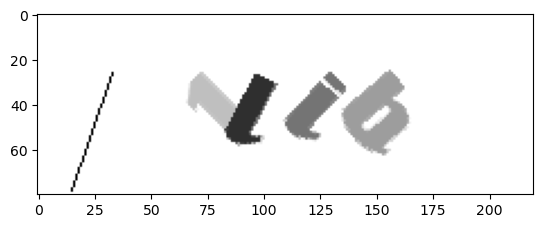

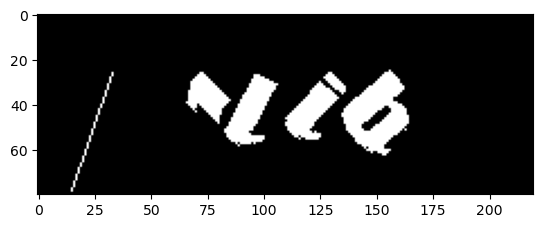

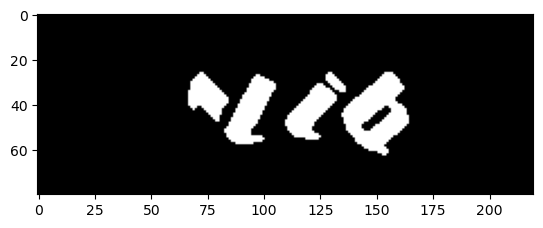

ValueError: not enough values to unpack (expected 3, got 1)

In [7]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# Create output folder for segmented characters
output_folder = "extracted_letter_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load the CAPTCHA image (colored image)
image_path = "train/1lib-0.png"
# image_path = "train/0axhfa-0.png"
image = cv2.imread(image_path)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
plt.show()

im_bw_inverted = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

plt.imshow(im_bw_inverted, cmap='gray')
plt.show()


image = cv2.medianBlur(im_bw_inverted, 3)
plt.imshow(image, cmap='gray')
plt.show()



# Split the image into its Red, Green, and Blue channels
B, G, R = cv2.split(image)

# Display each channel to inspect differences
plt.subplot(131)
plt.imshow(R, cmap='gray')
plt.title('Red Channel')
plt.subplot(132)
plt.imshow(G, cmap='gray')
plt.title('Green Channel')
plt.subplot(133)
plt.imshow(B, cmap='gray')
plt.title('Blue Channel')
plt.show()

# adaptive thresholding
thresh_R = cv2.adaptiveThreshold(R, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
thresh_G = cv2.adaptiveThreshold(G, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
thresh_B = cv2.adaptiveThreshold(B, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

plt.subplot(131)
plt.imshow(thresh_R, cmap='gray')
plt.title('Threshold Red Channel')
plt.subplot(132)
plt.imshow(thresh_G, cmap='gray')
plt.title('Threshold Green Channel')
plt.subplot(133)
plt.imshow(thresh_B, cmap='gray')
plt.title('Threshold Blue Channel')
plt.show()


# # Threshold each channel separately
# _, thresh_R = cv2.threshold(R, 100, 255, cv2.THRESH_BINARY_INV)
# _, thresh_G = cv2.threshold(G, 100, 255, cv2.THRESH_BINARY_INV)
# _, thresh_B = cv2.threshold(B, 100, 255, cv2.THRESH_BINARY_INV)
# # color channel for red and green only
# _, thresh_RG = cv2.threshold(cv2.merge((R, G, np.zeros_like(B))), 200, 255, cv2.THRESH_BINARY_INV)
# # color channel for green and blue only
# _, thresh_GB = cv2.threshold(cv2.merge((np.zeros_like(R), G, B)), 200, 255, cv2.THRESH_BINARY_INV)
# # color channel for red and blue only
# _, thresh_RB = cv2.threshold(cv2.merge((R, np.zeros_like(G), B)), 200, 255, cv2.THRESH_BINARY_INV)


# # Display the thresholded results for each channel
# plt.subplot(131)
# plt.imshow(thresh_R, cmap='gray')
# plt.title('Threshold Red Channel')
# plt.subplot(132)
# plt.imshow(thresh_G, cmap='gray')
# plt.title('Threshold Green Channel')
# plt.subplot(133)
# plt.imshow(thresh_B, cmap='gray')
# plt.title('Threshold Blue Channel')
# plt.show()
# plt.subplot(131)
# plt.imshow(thresh_RG, cmap='gray')
# plt.title('Threshold Red Green Channel')
# plt.subplot(132)
# plt.imshow(thresh_GB, cmap='gray')
# plt.title('Threshold Green Blue Channel')
# plt.subplot(133)
# plt.imshow(thresh_RB, cmap='gray')
# plt.title('Threshold Red Blue Channel')
# plt.show()

# # xor on all thresholded images 
# thresh_xor1 = cv2.bitwise_xor(thresh_R, thresh_G)
# thresh_xor2 = cv2.bitwise_xor(thresh_G, thresh_B)
# thresh_xor3 = cv2.bitwise_xor(thresh_R, thresh_B)
# plt.subplot(131)
# plt.imshow(thresh_xor1, cmap='gray')
# plt.title('XOR Red Green Channel')
# plt.subplot(132)
# plt.imshow(thresh_xor2, cmap='gray')
# plt.title('XOR Green Blue Channel')
# plt.subplot(133)
# plt.imshow(thresh_xor3, cmap='gray')
# plt.title('XOR Red Blue Channel')
# plt.show()



# Combine the channels if needed (depending on character separation)
# combined_thresh = cv2.bitwise_or(thresh_R, thresh_B)  # Example: Combining Red and Blue

# # Display the combined threshold
# plt.imshow(combined_thresh, cmap='gray')
# plt.title('Combined Threshold (R + B)')
# plt.show()

# # Now you can apply morphological operations and contour detection as before
# # Apply median blur to reduce noise
# combined_thresh = cv2.medianBlur(combined_thresh, 3)

# Apply Closing (Dilation followed by Erosion) to fill gaps
kernel = np.ones((3, 3), np.uint8)
img_closing = cv2.morphologyEx(combined_thresh, cv2.MORPH_CLOSE, kernel)
plt.imshow(img_closing, cmap='gray')
plt.title('After Closing (Dilation + Erosion)')
plt.show()

# Apply minimal Dilation (smaller kernel, fewer iterations)
dilation_kernel = np.ones((2, 2), np.uint8)
dilated = cv2.dilate(img_closing, dilation_kernel, iterations=1)
plt.imshow(dilated, cmap='gray')
plt.title('After Minimal Dilation')
plt.show()

# Find contours after thresholding and dilation
cnts = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

min_area = 50  # Adjusted min area for smaller characters
image_number = 0

for c in cnts:
    area = cv2.contourArea(c)
    if area > min_area:
        x, y, w, h = cv2.boundingRect(c)
        aspect_ratio = float(w) / h
        if 0.2 < aspect_ratio < 1.0 and w > 5 and h > 15:
            # Draw a rectangle around each detected character
            cv2.rectangle(dilated, (x, y), (x + w, y + h), (36, 255, 12), 2)
            # Extract each character as a Region of Interest (ROI)
            ROI = dilated[y:y+h, x:x+w]
            plt.imshow(ROI, cmap='gray')
            plt.title(f'Extracted Character {image_number}')
            plt.show()
            # Save the character as an individual image
            cv2.imwrite(os.path.join(output_folder, f"char_{image_number}.png"), ROI)
            image_number += 1

print("Segmentation completed!")
